# Disaster Tweets EDA

This notebook contains basic and/or complicated EDA.

In [56]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.util import ngrams

# set color codes
sns.set_color_codes('pastel')
plt.style.use('ggplot')


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/sample_submission.csv


### Loading the dataset

In [57]:
train = pd.read_csv('../input/nlp-getting-started/train.csv')
test = pd.read_csv('../input/nlp-getting-started/test.csv')
sample_submission = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')

In [58]:
print('Number of samples in train set: {}'.format(train.shape[0]))
print('Number of samples in test set: {}'.format(test.shape[0]))

Number of samples in train set: 7613
Number of samples in test set: 3263


### Distribution of the Target

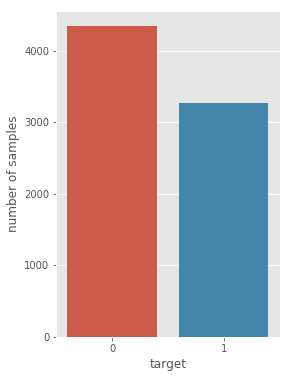

In [61]:
df = train.groupby(['target'])['id'].count()
df = df.reset_index()
df = df.rename(columns={'id': 'number of samples'})
fig, ax = plt.subplots(figsize=(4, 6))

sns.barplot(x='target', y='number of samples', data=df)

In [62]:
print('Number of disaster tweets: {}'.format(df.loc[df['target']==1]['number of samples'].values[0]))
print('Number of no disaster tweets: {}'.format(df.loc[df['target']==0]['number of samples'].values[0]))

Number of disaster tweets: 3271
Number of no disaster tweets: 4342


So, the classes are kind of balanced but we have about 1000 more samples in no disaster tweets.

### Number of Characters in Tweets

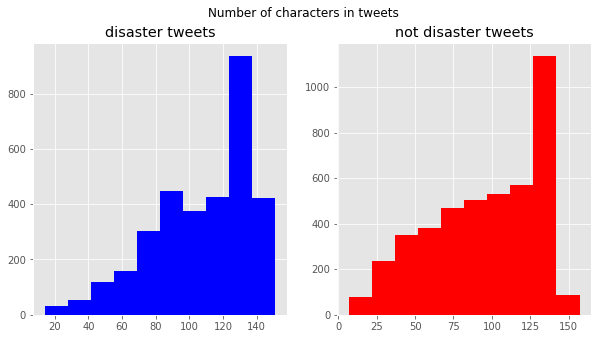

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

tweet_len = train.loc[train['target']==1]['text'].str.len()
ax1.hist(tweet_len, color='blue')
ax1.set_title('disaster tweets')
tweet_len = train.loc[train['target']==0]['text'].str.len()
ax2.hist(tweet_len, color='red')
ax2.set_title('not disaster tweets')

fig.suptitle('Number of characters in tweets')

plt.show()

Both diaster and not disaster tweets have almost same distribution on number of characters. 120 to 140 characters are most common in both groups.

### Number of Words in Tweets

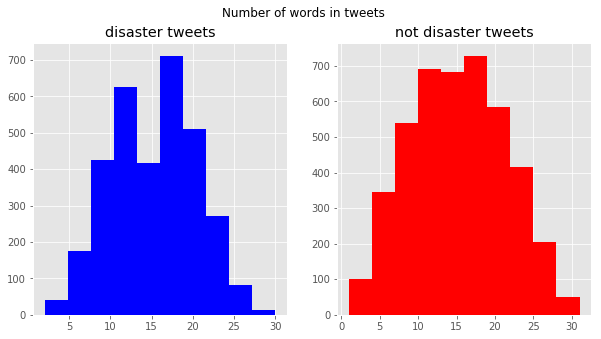

In [64]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
tweet_len = train.loc[train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len, color='blue')
ax1.set_title('disaster tweets')
tweet_len = train.loc[train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len, color='red')
ax2.set_title('not disaster tweets')

fig.suptitle('Number of words in tweets')

plt.show()

It seems not disaster tweets have slightly more words. This might be used as a feature!

### Average Word Length in Tweets

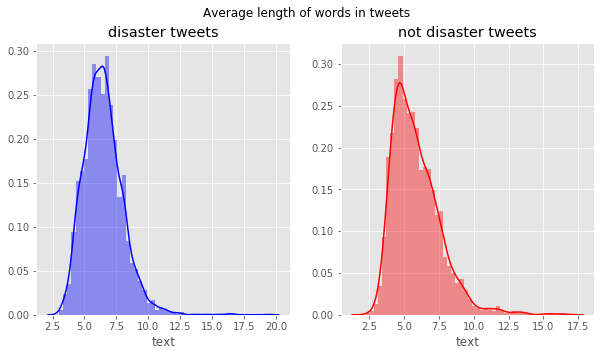

In [73]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

words = train.loc[train['target']==1] ['text'].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(words.map(lambda x: np.mean(x)), ax=ax1, color='blue')
ax1.set_title('disaster tweets')

words = train.loc[train['target']==0] ['text'].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(words.map(lambda x: np.mean(x)), ax=ax2, color='red')
ax2.set_title('not disaster tweets')

fig.suptitle('Average length of words in tweets')

plt.show()

Disaster and not disaster have almost same distribution over average length of words in them.

In [76]:
# funcion to make corpus
def make_corpus(df, target):
    corpus = []
    for x in df.loc[df['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

### Stop Words

In [77]:
# make a corpus of not disaster tweets
not_disaster_corpus = make_corpus(train, target=0)



In [79]:
len(corpus)

63848